In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload

import tree_utils
reload(tree_utils)
from tree_utils import *


In [2]:
data_raw = pd.read_csv("aps_failure_training_set.csv", skiprows = 20)

# Try to understand data
data_raw.shape
data_raw.head()

data_raw_small  = data_raw.iloc[0:10000,:]

#data_raw_small.apply(pd.value_counts)["na"]

from clean_data1 import clean_data
X, Y = clean_data(data_raw_small)

Y.value_counts(normalize=True)

# Y = Y.apply(lambda x: 1 if x =="neg" else 0)
Y.head()


/home/malcolm/Documents/aps_failure/clean_data1.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_raw.drop(large_pct_na, axis = 1, inplace= True)


Beginning to drop na's and nan's... this may take a while 
Finished replacing....
Shape before: (10000, 143)
Shape after: (10000, 142)


0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.25, random_state = 1)

compare_samples = pd.DataFrame({"Train":y_train.value_counts(normalize=True),
"Test": y_test.value_counts(normalize=True),
"Full":Y.value_counts(normalize=True)})

compare_samples

,Full,Test,Train
1,0.9805,0.9824,0.979867
0,0.0195,0.0176,0.020133


### Begin Random Forest Analysis 

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
rf_params = {"n_estimators" : 40, "max_depth":4, "random_state":4, "class_weight":{1:10, 0:500}}

estimator = RandomForestClassifier(**rf_params)
estimator.fit(X_train, y_train)

estimator.score(X_train, y_train)
preds1 = estimator.predict(X_train)

custom_score_aps(y_train, preds1)

          Pred_0  Pred_1
Actual_0     148       3
Actual_1     267    7082


0.556

          Pred_0  Pred_1
Actual_0      40       4
Actual_1     105    2351


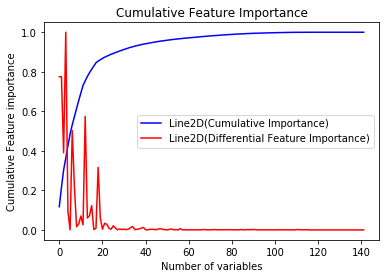

          Pred_0  Pred_1
Actual_0      40       4
Actual_1     105    2351


1.22

In [6]:
preds_test = estimator.predict(X_test)
custom_score_aps(y_test, preds_test)

len(estimator.feature_importances_)

# Feature importance stuff
feat_imp = pd.DataFrame(estimator.feature_importances_, index = X_train.columns, columns = ["Feat_Importance"])

feat_imp2 = get_cum_feat_imp(feat_imp)
plot_cum_feat_imp(feat_imp2)
custom_score_aps(y_test, preds_test)


In [7]:
cum_cutoff = 0.90
indiv_cutoff = 0.002
high_imp_feats1 = feat_imp2[feat_imp2["Cum_Imp"] < cum_cutoff]
print(len(high_imp_feats1))
high_imp_feats2 = feat_imp[feat_imp["Feat_Importance"] > indiv_cutoff]
print(len(high_imp_feats2))
high_imp_feats2.head()
# high_imp_feats1.to_csv("High_Importance_27vars.csv", index = False)
# high_imp_feats2.to_csv("High_Importance_43vars.csv", index = False)

27
43


,Feat_Importance
aa_000,0.117367
ag_002,0.002832
ag_003,0.008399
ag_004,0.006861
ah_000,0.062258


## Let's build a smaller Random Forest

In [8]:
X_train_small = X_train[high_imp_feats2.index]
X_test_small = X_test[high_imp_feats2.index]

In [9]:
small_est = RandomForestClassifier(**rf_params)
small_est.fit(X_train_small, y_train)

small_est.score(X_train_small, y_train)
preds2 = small_est.predict(X_train_small)

custom_score_aps(y_train, preds2)


          Pred_0  Pred_1
Actual_0     148       3
Actual_1     253    7096


0.5373333333333333

          Pred_0  Pred_1
Actual_0      40       4
Actual_1     106    2350


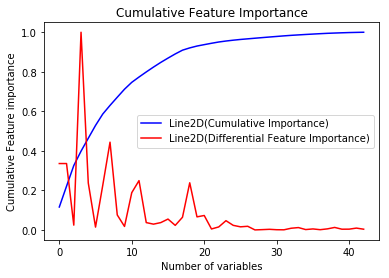

          Pred_0  Pred_1
Actual_0      40       4
Actual_1     106    2350


1.224

In [10]:
preds_test2 = small_est.predict(X_test_small)
custom_score_aps(y_test, preds_test2)

len(estimator.feature_importances_)

# Feature importance stuff
feat_imp_small = pd.DataFrame(small_est.feature_importances_, index = X_train_small.columns, columns = ["Feat_Importance"])

feat_imp_small2 = get_cum_feat_imp(feat_imp_small)
plot_cum_feat_imp(feat_imp_small2)
custom_score_aps(y_test, preds_test2)


### Begin examining correlations 

In [11]:
corr_df_raw = pd.concat([X_train_small, y_train], axis = 1)

In [12]:
corr_df_raw.shape

(7500, 44)

In [13]:
corr_df_raw.head()

,aa_000,ag_002,ag_003,ag_004,ah_000,al_000,am_0,ao_000,ap_000,aq_000,...,cs_002,cs_003,cs_004,cs_006,de_000,dn_000,dt_000,ee_000,ee_001,class
651,10,0,0,96,1580,0,0,17758,12208,470,...,18,10,180,1240,100,166,16,2976,1356,1
6560,409078,0,0,49444,13926286,660374,1198326,17536714,9891218,5651258,...,898036,174704,1096546,402,78,369890,12116,951194,530612,0
8974,91842,0,26116,586288,2955026,9966,14856,4528178,815134,439354,...,263454,347792,229642,1534732,106,41594,44760,758946,793972,1
2348,39896,0,0,115690,1139312,258,512,2130364,595560,145176,...,153534,129636,235872,136718,376,12458,7032,488442,247256,1
5670,98196,0,2258,184106,3254412,5400,8126,5347704,933460,398896,...,304416,398720,393604,681178,102,41540,44460,694408,1298672,1


In [14]:
corr = corr_df_raw.applymap(np.float64).corr()

In [15]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


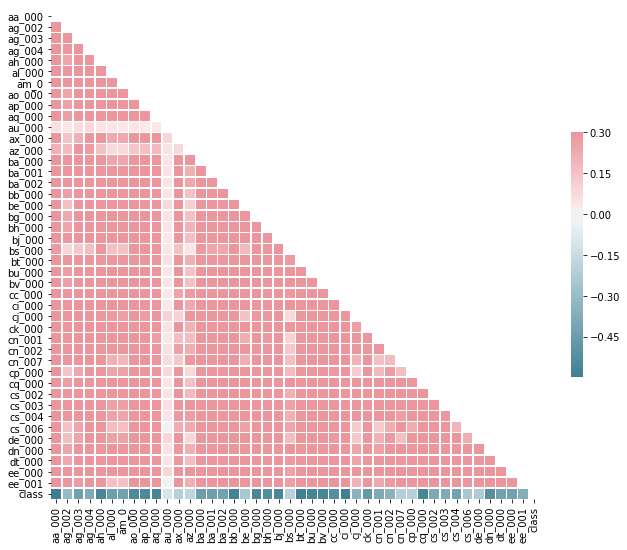

In [16]:
plt.show()

In [17]:
corr["class"]

aa_000   -0.597615
ag_002   -0.308480
ag_003   -0.432553
ag_004   -0.381792
ah_000   -0.561489
al_000   -0.444962
am_0     -0.429586
ao_000   -0.552920
ap_000   -0.545780
aq_000   -0.570137
au_000   -0.105877
ax_000   -0.207901
az_000   -0.177001
ba_000   -0.447897
ba_001   -0.438734
ba_002   -0.426786
bb_000   -0.573661
be_000   -0.248461
bg_000   -0.557961
bh_000   -0.528486
bj_000   -0.562229
bs_000   -0.198826
bt_000   -0.590391
bu_000   -0.568838
bv_000   -0.568838
cc_000   -0.523180
ci_000   -0.595626
cj_000   -0.351247
ck_000   -0.465113
cn_001   -0.382298
cn_002   -0.349071
cn_007   -0.211151
cp_000   -0.212898
cq_000   -0.568838
cs_002   -0.391677
cs_003   -0.383735
cs_004   -0.425193
cs_006   -0.247903
de_000   -0.227309
dn_000   -0.518883
dt_000   -0.425018
ee_000   -0.427670
ee_001   -0.365178
class     1.000000
Name: class, dtype: float64

In [18]:
feat_imp_small2.head()

,Feat_Importance,Cum_Imp,Diff_Feat_Imp
ck_000,0.115872,0.115872,0.335787
ci_000,0.105243,0.221115,0.335787
bu_000,0.104472,0.325587,0.024198
dn_000,0.072832,0.398419,1.000000
bt_000,0.065317,0.463736,0.237381


In [19]:
feats_corr = feat_imp_small2.join(corr["class"])

In [20]:
feats_corr.sort_values(by="class").head(7)

,Feat_Importance,Cum_Imp,Diff_Feat_Imp,class
aa_000,0.041254,0.671203,0.075613,-0.597615
ci_000,0.105243,0.221115,0.335787,-0.595626
bt_000,0.065317,0.463736,0.237381,-0.590391
bb_000,0.021806,0.869180,0.054858,-0.573661
aq_000,0.002253,0.986552,0.011830,-0.570137
bv_000,0.025653,0.799102,0.037016,-0.568838
bu_000,0.104472,0.325587,0.024198,-0.568838


In [21]:
feats_corr.sort_values(by="class").tail(7)

,Feat_Importance,Cum_Imp,Diff_Feat_Imp,class
de_000,0.006924,0.944182,0.004792,-0.227309
cp_000,0.006441,0.950623,0.015072,-0.212898
cn_007,0.002971,0.975823,0.003073,-0.211151
ax_000,0.002025,0.990767,0.005015,-0.207901
bs_000,0.000858,0.999262,0.009205,-0.198826
az_000,0.002634,0.984299,0.008496,-0.177001
au_000,0.001809,0.994558,0.005286,-0.105877


In [22]:
feats_corr.sort_values(by="Feat_Importance").head(7)

,Feat_Importance,Cum_Imp,Diff_Feat_Imp,class
ee_001,0.000738,1.000000,0.003607,-0.365178
bs_000,0.000858,0.999262,0.009205,-0.198826
be_000,0.001156,0.998403,0.003861,-0.248461
ba_002,0.001284,0.997247,0.003623,-0.426786
cs_006,0.001405,0.995963,0.012549,-0.247903
au_000,0.001809,0.994558,0.005286,-0.105877
cj_000,0.001982,0.992749,0.001161,-0.351247


### Begin exploring Predictions before LIME

In [23]:
def add_quantile_to_data(data, estimator, quantiles = np.arange(0, 1.1, 0.1), pred_number = 0):
    """
    Takes data and an estmiator and returns the scores and the score tiles 

    Inputs: 
        data (pandas df): should match the estimator 
        estimator
    
    
    """
    
    try:
        if estimator.n_features_ != data.shape[1]:
            print("NUmber of features in estimator is not equal to columns in dataframe")
    except AttributeError:
        print("Estimator does not have n_feature as attribute")
        pass 
    
    # Generate Predictions 
    preds_prob_test_raw = estimator.predict_proba(data)
    preds_prob_test = pd.DataFrame([x[pred_number] for x in preds_prob_test_raw], columns = ["scores"])
    # Get quantiles 
    pred_quantiles = preds_prob_test.quantile(quantiles)
    print("Quantiles:\n" ,pred_quantiles)
    # Append quantile rank to scores 
    n_unique_score_tiles = pred_quantiles.nunique()
    bin_labels = np.arange(0,n_unique_score_tiles-1) 
    preds_prob_test["quantiles"]  = pd.qcut(preds_prob_test["scores"], q = quantiles, labels = bin_labels, duplicates = 'drop')
    preds_prob_test["quantiles"] =  preds_prob_test["quantiles"].apply(np.float)
    
    # Merge original data with scores 
    data_scores = data.join(preds_prob_test)
    print("Final Shape: ", data_scores.shape)
    return(data_scores)

In [24]:
X_train2 = X_train_small.applymap(float)
X_test2 = X_test_small.applymap(float)
train_score_data = add_quantile_to_data(X_train2, small_est)
train_score_data.groupby("quantiles")["scores"].describe()

Quantiles:
        scores
0.0  0.001662
0.1  0.002022
0.2  0.002022
0.3  0.002022
0.4  0.002022
0.5  0.002798
0.6  0.007186
0.7  0.008517
0.8  0.027966
0.9  0.133547
1.0  0.979842


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'

Final Shape:  (7500, 45)


Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'double'


,count,mean,std,min,25%,50%,75%,max
quantiles,,,,,,,,
0.0,2604.0,0.002022,4.337642e-19,0.002022,0.002022,0.002022,0.002022,0.002022
1.0,467.0,0.002798,0.000000e+00,0.002798,0.002798,0.002798,0.002798,0.002798
2.0,599.0,0.005942,1.524582e-03,0.003124,0.004708,0.007186,0.007186,0.007186
3.0,260.0,0.007703,3.624159e-04,0.007382,0.007382,0.007382,0.008159,0.008496
4.0,554.0,0.017076,5.994634e-03,0.008820,0.011610,0.015927,0.022896,0.027966
5.0,548.0,0.053904,2.377615e-02,0.028022,0.035744,0.046023,0.064340,0.132678
6.0,573.0,0.583083,3.004703e-01,0.134017,0.294451,0.553921,0.895359,0.979842


We see that around 50% of the scores have a score around 0.002 or 0.2%  
The highest tile of scores are at 0.21

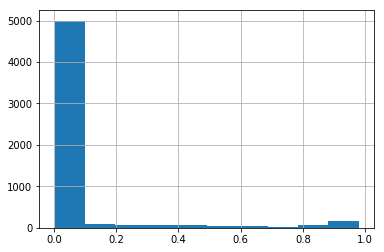

In [25]:
train_score_data["scores"].hist()
plt.show()

### Begin Using LIME 

In [26]:
import lime
import lime.lime_tabular

In [27]:
# Remember that lime explainer needs values as float 
# explainer_low = lime.lime_tabular.LimeTabularExplainer(high_data, feature_names = X_train2.columns, \
#                                                       discretize_continuous= False)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train2.values, \
                                                   feature_names = X_train2.columns,\
                                                   class_names = y_train.unique(), discretize_continuous= False)


In [28]:
# exp2 = explainer_low.explain_instance(high_data[0], small_est.predict_proba, num_features=5, num_samples=1000)
# exp3 = explainer_low.explain_instance(low_data[0], small_est.predict_proba, num_features = 5, num_samples = 1000)
# exp2.as_list()
# exp3.as_list()

In [29]:
low_data = train_score_data[train_score_data["quantiles"] == 1].drop(["scores", "quantiles"], axis =1).values
high_data = train_score_data[train_score_data["quantiles"] == 6].drop(["scores", "quantiles"], axis =1).values


In [30]:
print("High data shape:", high_data.shape)
print("Low data shape:", low_data.shape)

High data shape: (573, 43)
Low data shape: (467, 43)


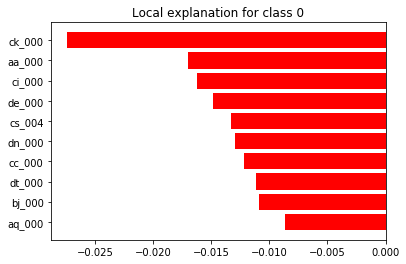

In [31]:
exp_l = explainer.explain_instance(low_data[0], small_est.predict_proba, num_features=10, num_samples = 2000)
exp_l.as_pyplot_figure()

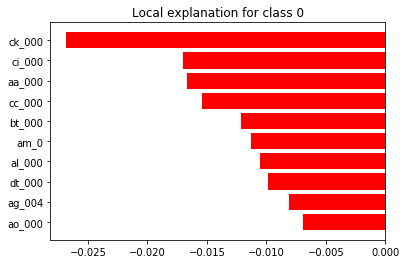

In [32]:
exp_h = explainer.explain_instance(high_data[0], small_est.predict_proba, num_features=10, num_samples = 2000)
exp_h.as_pyplot_figure()

In [33]:
print("Low observation Explainations: \n", exp_l.as_list())
print("\nHigh observation Explainations: \n", exp_h.as_list())

Low observation Explainations: 
 [('ck_000', -0.027435941760284566), ('aa_000', -0.01703445029455624), ('ci_000', -0.01625637160429996), ('de_000', -0.014867925811205449), ('cs_004', -0.013266999054586705), ('dn_000', -0.01291697009601665), ('cc_000', -0.01218256092039867), ('dt_000', -0.011123167328743522), ('bj_000', -0.010849140403673243), ('aq_000', -0.008665493020096055)]

High observation Explainations: 
 [('ck_000', -0.026808111557922), ('ci_000', -0.017010952938692668), ('aa_000', -0.016645411435252683), ('cc_000', -0.01537395833739034), ('bt_000', -0.012086556822532084), ('am_0', -0.011259817245777373), ('al_000', -0.01054668530960505), ('dt_000', -0.009862221354546726), ('ag_004', -0.008090989406965537), ('ao_000', -0.006931039419400301)]


In [34]:
def compare_explainations(exp1_full, exp2_full):
    
    def exp_df(exp):
        exp1 = exp.as_list()
        vars1 = {x[0]:x[1] for x in exp1}
        demo1 = pd.DataFrame(exp1)
        demo1.set_index(0, inplace = True)
        demo1.columns = ["coef"]
        return(demo1)
    
    demo1 = exp_df(exp1_full)
    demo2 = exp_df(exp2_full)
    
    # Merge and aggregate
    demo_all = demo1.join(demo2, how="outer", lsuffix = "_1", rsuffix="_2")
    demo_all["diff"] = demo_all["coef_1"] - demo_all["coef_2"]
    demo_all["diff_o_avg"] = demo_all["diff"]/np.nanmean([demo_all["coef_1"], demo_all["coef_2"]])
    n_solo_vars = demo_all["diff"].isna().sum()
    n_matched = demo_all.shape[0] - n_solo_vars
    
    # Outputs 
    print("Total size is: ", demo_all.shape[0])
    print("Number of matched vars: ", n_matched)
    print("Vars with only one match: ", n_solo_vars)

    return(demo_all)


In [35]:
comp_exps = compare_explainations(exp_l, exp_h)

Total size is:  15
Number of matched vars:  5
Vars with only one match:  10


In [36]:
# Have matches in both datasets 
comp_exps.dropna(axis = 0)

,coef_1,coef_2,diff,diff_o_avg
0,,,,
aa_000,-0.017034,-0.016645,-0.000389,0.027867
cc_000,-0.012183,-0.015374,0.003191,-0.228598
ci_000,-0.016256,-0.017011,0.000755,-0.054050
ck_000,-0.027436,-0.026808,-0.000628,0.044971
dt_000,-0.011123,-0.009862,-0.001261,0.090321


We can see there are some similarities between an observation in the high class and the low class.  
Some of the variables are the same and the numbers are very similar and some of the less important variables are different and have varying significances.  
It can be interesting to see how the variables and magnitude of the effect changes by tile 

In [37]:
# Get explainations for an instance 

def get_top_feats(row, estimator, explainer, num_features = 5, num_samples=1000): 
    """
    Returns feature name and normalized coefficient from explainer "explain instance" 

    """
    exp1 = explainer.explain_instance(row, estimator.predict_proba, num_features=num_features, num_samples=num_samples)
    feat_list = exp1.as_list()
    get_name = lambda y: y[0].split()[0] # Incase you forget to discretize 
    feats = [(get_name(x), x[1]) for x in feat_list]
#     feats = pd.Series({get_name(x): x[1] for x in feat_list })
    
    return(feats)


In [38]:
print("Number of low scores: ", len(low_data))
print("Number of high scores: ", len(high_data))

Number of low scores:  467
Number of high scores:  573


In [39]:
# row_temp = high_data[1,:]
# demo1 = pd.DataFrame(high_data.T[:,:3]).apply(lambda x: get_top_feats(x, small_est, explainer, num_samples=30), axis = 0)

In [41]:
n_obs = 50
high_score_feats = [get_top_feats(x, small_est, explainer) for x in high_data[:n_obs]]

In [42]:
def get_feature_gb(feats_coef_list):
    # Concatenate each explaination score into one dataframe 
    master_df_low = pd.DataFrame()
    for exp in feats_coef_list:
        temp_df = pd.DataFrame(exp)
        master_df_low = pd.concat([master_df_low, temp_df], axis = 0)
    master_df_low.columns = ["Feature",  "Coefficient"]
    print("Df full shape: ", master_df_low.shape)
    
    low_feat_coef_gb = master_df_low.groupby("Feature")
#     low_feat_coef_gb.describe()
#     cnt_mean_low = low_feat_coef_gb.apply(lambda x: (np.mean(x)[0], len(x)))
#     cnt_mean_low.sort_values("count", ascending = False).head()    
    # Gather metrics from each 
    cnt_mean_low = master_df_low.groupby("Feature").apply(lambda x: pd.Series({"mean": np.mean(x)[0],
                                                                           "count":len(x), 
                                                                           "abs_mean":abs(np.mean(x)[0]), 
                                                                           "mean_sign":"pos" if np.mean(x)[0] > 0 else "neg" }))
    cnt_mean_low.sort_values("count", ascending=False, inplace = True)
    print(cnt_mean_low.head())
    return(cnt_mean_low)

In [43]:
feat_gb = get_feature_gb(high_score_feats)

Df full shape:  (250, 2)
         abs_mean  count      mean mean_sign
Feature                                     
ck_000   0.028473     50 -0.028473       neg
aa_000   0.016446     44 -0.016446       neg
ci_000   0.015877     40 -0.015877       neg
ag_002   0.014022     24 -0.014022       neg
de_000   0.015116     23 -0.015116       neg


In [ ]:
# Concatenate each explaination score into one dataframe 
master_df_low = pd.DataFrame()
for exp in high_score_feats:
    temp_df = pd.DataFrame(exp)
    master_df_low = pd.concat([master_df_low, temp_df], axis = 0)
master_df_low.columns = ["Feature",  "Coefficient"]
print("Master df low shape: ", master_df_low.shape)

In [ ]:
low_feat_coef_gb = master_df_low.groupby("Feature")
cnt_mean_low = low_feat_coef_gb.apply(lambda x: (np.mean(x)[0], len(x)))
low_feat_coef_gb.describe()


In [ ]:
# Gather metrics from each 
cnt_mean_low = master_df_low.groupby("Feature").apply(lambda x: pd.Series({"mean": np.mean(x)[0],
                                                                       "count":len(x), 
                                                                       "abs_mean":abs(np.mean(x)[0]), 
                                                                       "mean_sign":"pos" if np.mean(x)[0] > 0 else "neg" }))


In [ ]:
cnt_mean_low.sort_values("count", ascending = False).head()


In [ ]:
cnt_mean_low.sort_values("abs_mean", ascending = False).head()

In [ ]:
master_df_high = pd.DataFrame()
for exp in high_score_feats:
    temp_df = pd.DataFrame(exp)
    master_df_high = pd.concat([master_df_high, temp_df], axis = 0)
master_df_high.columns = ["Feature",  "Coefficient"]
print("Master df high shape: ", master_df_high.shape)

In [ ]:
high_feat_coef_gb = master_df_high.groupby("Feature")
cnt_mean_high = high_feat_coef_gb.apply(lambda x: (np.mean(x)[0], len(x)))
high_feat_coef_gb.describe()
# Gather metrics from each feature group by 
cnt_mean_high = master_df_high.groupby("Feature").apply(lambda x: pd.Series({"mean": np.mean(x)[0],
                                                                       "count":len(x), 
                                                                       "abs_mean":abs(np.mean(x)[0]), 
                                                                       "mean_sign":"pos" if np.mean(x)[0] > 0 else "neg" }))



In [ ]:
cnt_mean_high.sort_values("count", ascending = False).head()


In [ ]:
cnt_mean_high.sort_values("abs_mean", ascending = False).head()

In [ ]:
high_low_mean_cnt = cnt_mean_high.join(cnt_mean_low, how="outer", lsuffix="_high", rsuffix="_low")

In [ ]:
high_low_mean_cnt["cnt_diff"] = high_low_mean_cnt["count_high"] - high_low_mean_cnt["count_low"]
high_low_mean_cnt["mean_diff"] = high_low_mean_cnt["mean_high"] - high_low_mean_cnt["mean_low"]

In [ ]:
high_low_mean_cnt.head()

In [ ]:
high_low_mean_cnt["cnt_diff"]

In [ ]:
high_low_mean_cnt["mean_diff"]